# Research Question 2: How did the performance treatments influence the relevant metrics of the Climate Superemulator?
## RQ 2.2: How strongly does changing to an A100 GPU influence Execution time or GPU utilization?

In [2]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pip install jinja2

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
pip install pingouin

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\fe-na\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import statistics


## Setup and Data Loading from Wandb

In [8]:
api = wandb.Api()

A100 = api.runs(f"causalpaca/emulator", filters = {'group' : "A100", 'tags': "6_models"})
RTX8000 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "6_models"})
Treatment_Names = ["Baseline", "A100"]
Treatments = [RTX8000,A100]

print(len(A100))
print(len(RTX8000))
if(len(A100) ==len(RTX8000)):
    print("continue")
else: 
    print("A100 and Baseline do not have same amounts of runs!")


8
8
continue


In [9]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      name = extract_parts_from_name(model.name)

      # Retrieving system metrics history
      system_metrics = model.history(stream="systemMetrics")
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      defaults = model.history()

      # Scanning history for default metrics
      still_running = False


      time = model.summary["_wandb"].runtime/60 # in minutes
      emissions = model.summary["emissions"]
      default_metrics = model.history(stream="default",pandas=True)
      train_time = default_metrics["time/train"].dropna().to_numpy()
      epoch = default_metrics["epoch"].dropna().to_numpy()
      accuracy = default_metrics["val/rmse"].dropna().to_numpy()
      steps = default_metrics['_step'].tolist()
      # Creating DataFrame for the filtered default metrics and steps
      #val_rmse_df = pd.DataFrame({'val/rmse': val_rmse}).fillna(method='ffill')

      # Extracting runtime values from system metrics
      runtime_values = system_metrics['_runtime']

      #print(name,Treatment_Names[index], len(steps),len(epoch))
      runtime_hours = model.summary["_wandb"].runtime / 60 / 60
      # Create a new DataFrame for the current row
      data.append({
        "treatment": Treatment_Names[index],
        "name": name,
        "Time/Train": train_time,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "RSS-Memory in GB": system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list(),
        "RMSE": accuracy,
        "Steps": steps,
        "runtime_hours": runtime_hours,
        "Co2": emissions,
        "Epoch": epoch,
      })
      print(name, statistics.mean(train_time))
# Convert the list of dictionaries to a DataFrame


unet 46.768137498335406
convlstm 16.57738983631134
climax_frozen 102.9874267578125
climax 142.52176310221355
climax 141.6167019114775
unet 47.26617121696472
convlstm 9.835968116234088
climax_frozen 99.424805179719
unet 26.009610863619073
convlstm 9.854442051478795
climax_frozen 89.13165406257876
climax 125.45772661481585
unet 25.324775165981716
convlstm 19.008877012464737
climax_frozen 112.411630859375
climax 136.95782725016275


In [10]:
runs_count = {}
for d in data:
    key = (d["name"], d["treatment"])
    runs_count[key] = runs_count.get(key, 0) + 1
print(runs_count)

{('unet', 'Baseline'): 2, ('convlstm', 'Baseline'): 2, ('climax_frozen', 'Baseline'): 2, ('climax', 'Baseline'): 2, ('unet', 'A100'): 2, ('convlstm', 'A100'): 2, ('climax_frozen', 'A100'): 2, ('climax', 'A100'): 2}


In [11]:
# Merge the Multiples
mean_data = {}
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    print(number_runs)
    print()
    print(run[0],run[1])
    CPU_Lists=[]
    GPU_Lists=[]
    RSS_Lists=[]
    RMSE_Lists=[]
    Steps_Lists=[]
    Runtime_Lists=[]
    Time_train_list = []
    CO2_Lists=[]
    for d in data: 
        if d["name"] == run[0] and d["treatment"] == run[1]:
            CPU_Lists.append(d["CPU"])
            GPU_Lists.append(d["GPU"])
            RSS_Lists.append(d["RSS-Memory in GB"])
            RMSE_Lists.append(d["RMSE"])
            Steps_Lists.append(d["Steps"])
            Runtime_Lists.append(d["runtime_hours"])
            CO2_Lists.append(d["Co2"])
            Time_train_list.append(d["Time/Train"])
    
    if (number_runs>=2):
        mean_data[(run[0], run[1])] = {
            "time/train": [(x + y)/2 for x, y in zip(Time_train_list[0], Time_train_list[1])],
            "CPU": [(x + y)/2 for x, y in zip(CPU_Lists[0], CPU_Lists[1])],
            "GPU": [(x + y)/2 for x, y in zip(GPU_Lists[0], GPU_Lists[1])],
            "RSS-Memory in GB": [(x + y)/2 for x, y in zip(RSS_Lists[0], RSS_Lists[1])],
            "RMSE":  [(x + y)/2 for x, y in zip(RMSE_Lists[0], RMSE_Lists[1])],
            "Steps": [(x + y)/2 for x, y in zip(Steps_Lists[0], Steps_Lists[1])],
            "runtime_hours": statistics.mean(Runtime_Lists),
            "Co2": statistics.mean(CO2_Lists)
        }
    else:
        print("skipped")

print(mean_data)

2

unet Baseline
2

convlstm Baseline
2

climax_frozen Baseline
2

climax Baseline
2

unet A100
2

convlstm A100
2

climax_frozen A100
2

climax A100
{('unet', 'Baseline'): {'time/train': [48.58627510070801, 47.19487953186035, 46.660823822021484, 46.97189712524414, 46.904096603393555, 46.76623725891113, 46.82633399963379, 46.673858642578125, 47.14164924621582, 46.598398208618164, 47.26079750061035, 47.2443904876709, 47.242557525634766, 46.734663009643555, 46.89813995361328, 46.74839401245117, 46.72187805175781, 47.54465866088867, 47.554853439331055, 47.37467956542969, 47.4197998046875, 46.99462127685547, 46.87406349182129, 46.60909080505371, 47.1323184967041, 47.30131912231445, 46.665571212768555, 46.90336227416992, 46.56234359741211, 47.006813049316406, 46.60166358947754, 46.797889709472656], 'CPU': [1.5150000000000001, 2.935, 3.0149999999999997, 3.05, 2.88, 2.98, 2.9450000000000003, 2.9400000000000004, 3.0, 2.9050000000000002, 2.9850000000000003, 2.975, 2.8899999999999997, 2.975, 2.9

## Overview of Mean, Median and STD

In [20]:
data_scheme={
    "CPU": [],
    "GPU": [],
    "RSS-Memory in GB": [],
    "RMSE": 0,
    "Steps": [],
    "runtime_hours": 0,
    "Co2": 0
}

rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]),0)
    if(number_runs>=2):
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]),0)
        new_row = {
            "Name":name, 
            "Treatment":treatment, 
            "CPU_Mean": statistics.mean(data_for_run["CPU"]), 
            "CPU_Median": statistics.median(data_for_run["CPU"]), 
            "CPU_STD": statistics.stdev(data_for_run["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run["GPU"]), 
            "GPU_Median": statistics.median(data_for_run["GPU"]), 
            "GPU_STD": statistics.stdev(data_for_run["GPU"]), 
            "Time/Train Mean_Minutes": statistics.mean(data_for_run["time/train"])/60,
            "Time/Train Median_Minutes": statistics.median(data_for_run["time/train"])/60,
            "Time/Train STD_Minutes": statistics.stdev(data_for_run["time/train"])/60,
            "RSS-Memory_Mean": statistics.mean(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_Median": statistics.median(data_for_run["RSS-Memory in GB"]), 
            "RSS-Memory_STD": statistics.stdev(data_for_run["RSS-Memory in GB"]), 
            "RMSE": min(data_for_run["RMSE"]), 
            "runtime_hours": data_for_run["runtime_hours"], 
            "Co2": data_for_run["Co2"]}
        
        rows.append(new_row)


already_used_name=[]
scaling_factor_rows = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]

        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        new_row = {
            "Name":name, 
            "CPU_Mean": statistics.mean(data_for_run_1["CPU"])/statistics.mean(data_for_run_0["CPU"]), 
            "GPU_Mean": statistics.mean(data_for_run_1["GPU"])/statistics.mean(data_for_run_0["GPU"]), 
            "RSS-Memory_Mean": statistics.mean(data_for_run_1["RSS-Memory in GB"])/statistics.mean(data_for_run_0["RSS-Memory in GB"]), 
            "RMSE": statistics.mean(data_for_run_1["RMSE"])/statistics.mean(data_for_run_0["RMSE"]), 
            "Time_Trainn": statistics.mean(data_for_run_1["time/train"])/statistics.mean(data_for_run_0["time/train"]),
            "runtime_hours": data_for_run_1["runtime_hours"]/data_for_run_0["runtime_hours"], 
            "Co2": data_for_run_1["Co2"]/data_for_run_0["Co2"]}
        
        scaling_factor_rows.append(new_row)

new_df = pd.DataFrame(rows)
new_df_sf = pd.DataFrame(scaling_factor_rows)
sorted_df = new_df.sort_values(by='Name')
sorted_df_sf = new_df_sf.sort_values(by='Name')
def round_if_float(x):
    if isinstance(x, float):
        rounded_value = round(x, 3)
        return rounded_value
    return x
sorted_df = sorted_df.applymap(round_if_float)
sorted_df_sf = sorted_df_sf.applymap(round_if_float)
selected_column0 = ['Name', 'Treatment',"CPU_Mean","GPU_Mean", "RSS-Memory_Mean","RMSE", "runtime_hours"]
selecteddf_0 = sorted_df[selected_column0].copy()
print(selecteddf_0.to_latex(index=False,float_format="%.3f"))
selected_column = ['Name', 'Treatment',"Time/Train Mean_Minutes"]
selecteddf = sorted_df[selected_column].copy()

latex_table = sorted_df.to_latex(index=False,float_format="%.3f")
latex_table_sf = sorted_df_sf.to_latex(index=False,float_format="%.3f")


# print(latex_table)
# print(latex_table_sf)



\begin{tabular}{llrrrrr}
\toprule
Name & Treatment & CPU_Mean & GPU_Mean & RSS-Memory_Mean & RMSE & runtime_hours \\
\midrule
climax & Baseline & 1.933 & 55.691 & 13919.407 & 1.150 & 3.972 \\
climax & A100 & 0.438 & 40.415 & 15142.309 & 0.929 & 3.763 \\
climax_frozen & Baseline & 2.108 & 48.207 & 14698.728 & 0.635 & 2.822 \\
climax_frozen & A100 & 0.440 & 35.297 & 15744.673 & 0.660 & 2.710 \\
convlstm & Baseline & 4.486 & 34.851 & 8157.944 & 0.560 & 0.375 \\
convlstm & A100 & 0.900 & 31.895 & 8117.530 & 0.553 & 0.434 \\
unet & Baseline & 2.943 & 85.362 & 6913.844 & 1.258 & 1.332 \\
unet & A100 & 0.594 & 64.261 & 6931.695 & 1.246 & 0.811 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_15312\836868369.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df = sorted_df.applymap(round_if_float)
C:\Users\fe-na\AppData\Local\Temp\ipykernel_15312\836868369.py:75: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_sf = sorted_df_sf.applymap(round_if_float)


In [13]:
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from seaborn_qqplot import pplot
from scipy.stats import gamma
from PIL import Image
import statsmodels.api as sm 
import pylab as py 



def violin_plot(ax, data, name, unit):
    sns.violinplot(data=data, ax=ax, inner="box", color="#c895d9")
    ax.set_title(name)
    ax.set_xlabel("Data Distribution")
    ax.set_ylabel(unit)

def density_plot(ax, data, name, unit):
    sns.kdeplot(data=data, fill=True, color="#c895d9", ax=ax)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")


def qq_plot(ax, data, name, line_color="#c895d9"):
    # multirow = [{"Theoretical_Quantiles":np.array((stats.norm.ppf(np.arange(1, len(data)+1) / (len(data)+1))),dtype=float), "species":0}]
    # df = pd.DataFrame(multirow)
    # df_new = df.explode("Theoretical_Quantiles").astype(float)
    # # Plot the quantiles
    # pairGrid = pplot(df_new, x="Theoretical_Quantiles",y=gamma, kind='qq', height=5, aspect=1, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})
    # pairGrid.add_legend(title=name)
    # pairGrid.figure.savefig(f"figures/{name}")
    # sm.qqplot(np.array(data), line ='45') 
    pp = sm.ProbPlot(np.array(data), fit=True)
    qq = pp.qqplot(ax=ax, marker='.', markerfacecolor='k', alpha=0.3, color='#1f77b4')
    sm.qqline(ax=ax, line='45', fmt='k--')
    ax.set_title(name)
    
    

def density_plot_2(ax, treatment_0, treatment_1,name_0,name_1, name, unit):
    sns.kdeplot(data=treatment_0, fill=True, color="#c895d9", ax=ax, label=name_0)
    sns.kdeplot(data=treatment_1, fill=True, color="#ff6f61", ax=ax, alpha=0.5, label=name_1)
    ax.set_title(name)
    ax.set_xlabel(unit)
    ax.set_ylabel("Density")
    ax.legend()

def scale_down(data,factor=6.0):
    new_data = []
    for x in data:
        new_x = x / factor
        new_data.append(new_x)
    return new_data
        

############################################ VIOLIN & DENSITY PLOTS ############################################################

# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)
        
#         fig, axes = plt.subplots(1, 2, figsize=(18, 12))  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             violin_plot(axes[0], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # violin_plot(axes[0, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             density_plot(axes[1], data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 1], data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}", "Percent")
#             # density_plot(axes[1, 2], data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
            
#             plt.tight_layout()
#             fig.savefig(f"figures/RQ_2.2_violin_density/RQ_2.2_violin_density_{name}-{treatment}.png")    

############################################ QQ PLOTS ############################################################
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if number_runs >= 2:
#         name = run[0]
#         treatment = run[1]
#         data_for_run = mean_data.get((run[0], run[1]), 0)

#         fig, axes = plt.subplots(1, 1, figsize=(15, 5),)  # Create a 2x3 grid of subplots
#         if(run[1] != "Baseline"): 
#             qq_plot(axes,data_for_run["GPU"], f"GPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[1],data_for_run["CPU"], f"CPU - {run[0]}-{run[1]}")
#             # qq_plot(axes[2],data_for_run["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}")

#             fig.savefig(f"figures/RQ_2.2_QQ/RQ_2_QQ_{name}-{treatment}")        
         # will now save all plots

############################################ COMBINED DENSITY PLOTS ############################################################


# already_used_name=[]
# for run in runs_count: 
#     number_runs = runs_count.get((run[0], run[1]), 0)
#     if(number_runs >= 2 and (run[0] not in already_used_name)):
#         already_used_name.append(run[0])
#         name = run[0]
#         treatment_0 = Treatment_Names[0]
#         treatment_1 = Treatment_Names[1]

#         data_for_run_0 = mean_data.get((run[0], treatment_0), 0)
#         data_for_run_1 = mean_data.get((run[0], treatment_1), 0)

        

#         fig, axes = plt.subplots(1, 3, figsize=(18, 12))  # Create a 2x3 grid of subplots

#         density_plot_2(axes[0], data_for_run_0["GPU"],data_for_run_1["GPU"], f"GPU - {run[0]}", "Percent")
#         density_plot_2(axes[1], data_for_run_0["CPU"],data_for_run_1["CPU"], f"CPU - {run[0]}", "Percent")
#         density_plot_2(axes[2], data_for_run_0["RSS-Memory in GB"],data_for_run_1["RSS-Memory in GB"], f"RSS-Memory - {run[0]}-{run[1]}", "GB")
        
#         plt.tight_layout()
#         fig.savefig(f"figures/RQ_2.2_combined_density/{name}-{treatment}.png")        





In [14]:
from scipy import stats


data_list_shapiro = []

for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if number_runs >= 2:
        name = run[0]
        treatment = run[1]
        data_for_run = mean_data.get((run[0], run[1]), 0)
        
        SWT_GPU = stats.shapiro(data_for_run["CPU"])
        SWT_CPU = stats.shapiro(data_for_run["GPU"])
        SWT_RSS = stats.shapiro(data_for_run["RSS-Memory in GB"])
        
        data_list_shapiro.append({
            "Name": name,
            "Treatment": treatment,
            "GPU-Statistic": SWT_GPU.statistic,
            "GPU-P": SWT_GPU.pvalue,
        })
        
df_Shapiro = pd.DataFrame(data_list_shapiro)
sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)
latex_table_shapiro = sorted_df_shapiro.to_latex(index=False,float_format="%.3f")

print(latex_table_shapiro)
        

\begin{tabular}{llrr}
\toprule
Name & Treatment & GPU-Statistic & GPU-P \\
\midrule
climax & Baseline & 0.925 & 0.000 \\
climax & A100 & 0.876 & 0.000 \\
climax_frozen & Baseline & 0.971 & 0.000 \\
climax_frozen & A100 & 0.902 & 0.000 \\
convlstm & Baseline & 0.248 & 0.000 \\
convlstm & A100 & 0.649 & 0.000 \\
unet & Baseline & 0.293 & 0.000 \\
unet & A100 & 0.535 & 0.000 \\
\bottomrule
\end{tabular}



C:\Users\fe-na\AppData\Local\Temp\ipykernel_15312\378479273.py:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sorted_df_shapiro = df_Shapiro.sort_values(by='Name').applymap(round_if_float)


unet Baseline
unet A100
157 157


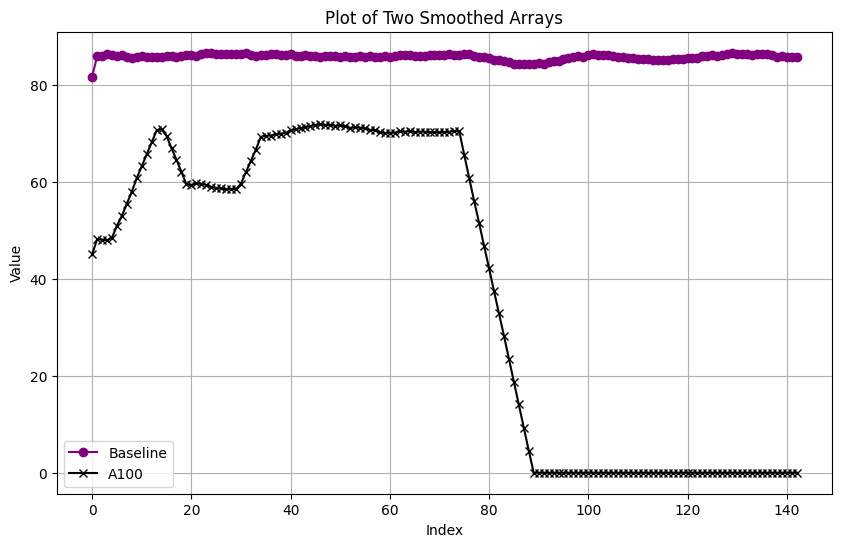

13346.555 5706.535
convlstm Baseline
convlstm A100
33 33


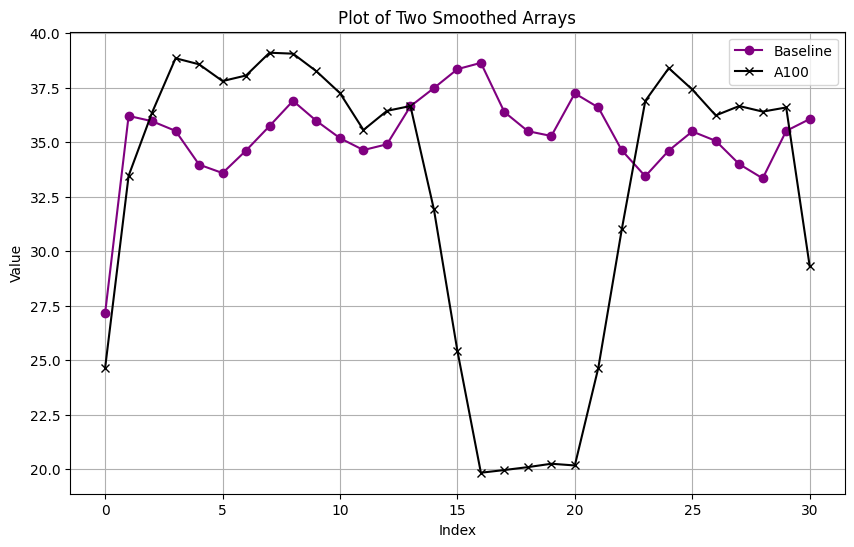

1127.4650000000001 1038.7150000000001
climax_frozen Baseline
climax_frozen A100
329 329


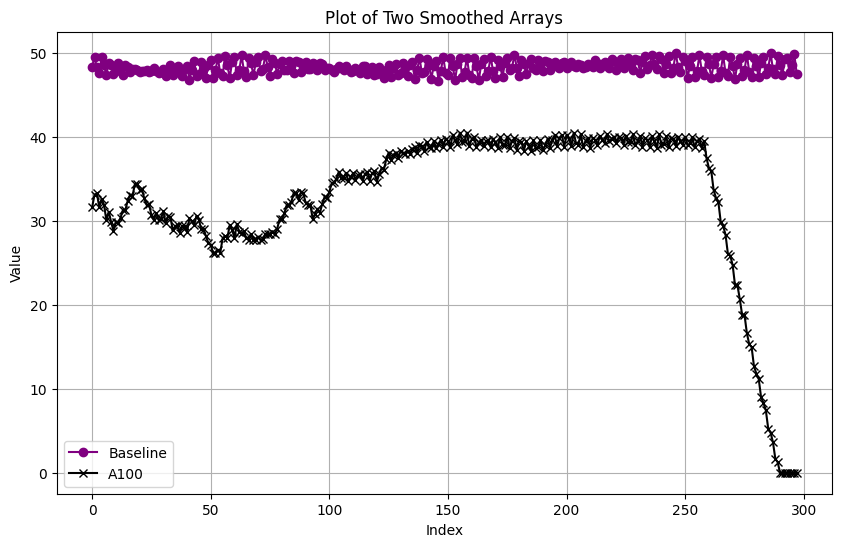

15849.0075 10232.8325
climax Baseline
climax A100
470 470


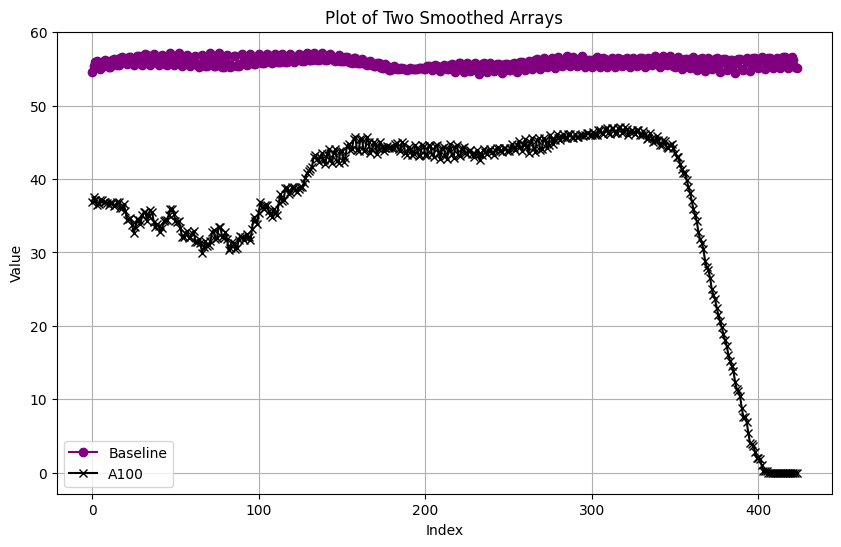

26159.4875 16407.5325


In [15]:

from scipy import stats
import matplotlib.patches as mpatches

def smooth_array(array, factor=0.1):
    """
    Applies a moving average to smooth the array.

    Parameters:
    array (list or np.array): The array to smooth.
    factor (float): The smoothing factor. Determines the window size.

    Returns:
    np.array: The smoothed array.
    """
    window_size = int(len(array) * factor)
    if window_size < 1:
        window_size = 1
    smoothed_array = np.convolve(array, np.ones(window_size)/window_size, mode='valid')
    return smoothed_array

def plot_arrays(array1, array2, label_1='Array 1', label_2='Array 2'):
    """
    Plots two smoothed arrays on a single diagram with a purple and black color scheme.

    Parameters:
    array1 (list or np.array): The first array to plot.
    array2 (list or np.array): The second array to plot.
    label_1 (str): Label for the first array.
    label_2 (str): Label for the second array.

    Returns:
    None
    """
    smoothed_array1 = smooth_array(array1)
    smoothed_array2 = smooth_array(array2)

    plt.figure(figsize=(10, 6))

    plt.plot(smoothed_array1, label=label_1, marker='o', color='purple')
    plt.plot(smoothed_array2, label=label_2, marker='x', color='black')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of Two Smoothed Arrays')
    plt.legend()
    plt.grid(True)
    plt.show()

def integral_below_curve(arr):
    # Calculate the width of each interval
    dx = 1  # Assuming the intervals are of unit width

    # Use the trapezoidal rule for numerical integration
    integral = np.trapz(arr, dx=dx)
    return integral

data_list_rank_sum = []
already_used_name=[]
arr_of_integrals = []
for run in runs_count: 
    number_runs = runs_count.get((run[0], run[1]), 0)
    if(number_runs >= 2 and (run[0] not in already_used_name)):
        already_used_name.append(run[0])
        name = run[0]
        treatment_0 = Treatment_Names[0]
        treatment_1 = Treatment_Names[1]
        print(run[0], treatment_0)
        print(run[0], treatment_1)
        
        data_for_run_0 = mean_data.get((run[0], treatment_0), 0)["GPU"]
        data_for_run_1 = mean_data.get((run[0], treatment_1), 0)["GPU"]
        big_len = len(data_for_run_0)
        if(len(data_for_run_0)>len(data_for_run_1)):
            pad = len(data_for_run_0) - len(data_for_run_1)
            data_for_run_1 = data_for_run_1 + [0] * (pad)
        else: 
            pad = len(data_for_run_1) - len(data_for_run_0)
            data_for_run_0 = data_for_run_0 + [0] * (pad)

        print(len(data_for_run_0),len(data_for_run_1))

        plot_arrays(data_for_run_0,data_for_run_1, treatment_0,treatment_1)
        # Calculate the integrals below the curves
        integral1 = integral_below_curve(data_for_run_0)
        integral2 = integral_below_curve(data_for_run_1)
        print(integral1,integral2)
        arr_of_integrals.append({f"{name}-{treatment_0}":integral1, f"{name}-{treatment_1}":integral2})
        # SWT_CPU = stats.spearmanr(gpu_0, gpu_1)

       

        # data_list_rank_sum.append({
        #     "Name": name,
        #     "GPU-Statistic-RS": SWT_GPU.statistic,
        #     "GPU-P-RS": SWT_GPU.pvalue,
        # })



In [16]:
newdfforthis = pd.DataFrame(arr_of_integrals)

# Split column names and extract the first part as the treatment
names = list(set(newdfforthis.columns.str.split('-').str[0]))
newdfforthis['names'] = names

# Reorder the columns with 'treatment' as the first column
cols = ['names'] + [col for col in newdfforthis.columns if col != 'names']
data = newdfforthis[cols]

df = pd.DataFrame(data)

# Extract Baseline and A100 columns for each treatment
baseline_cols = [col for col in df.columns if 'Baseline' in col]
A100_cols = [col for col in df.columns if 'A100' in col]

# Create new columns for Baseline and A100
df['RTX8000'] = df[baseline_cols].sum(axis=1)
df['A100'] = df[A100_cols].sum(axis=1)

# Drop the old treatment-specific columns
df.drop(columns=baseline_cols + A100_cols, inplace=True)

# Add a new column "Treatment"
df['Treatment'] = df.apply(lambda row: 'RTX8000' if 'RTX8000' in row['names'] else 'A100', axis=1)

# Melt the DataFrame to combine the "RTX8000_GPU" and "A100_GPU" columns into one column called "GPU"
df = pd.melt(df, id_vars=['names', 'Treatment'], var_name='GPU', value_name='value')
df.drop(columns=['Treatment'], inplace=True)

# Rename the columns
df.rename(columns={'GPU': 'Treatment', 'value': 'GPU_Percent'}, inplace=True)
df.rename(columns={'names': 'Name'}, inplace=True)

selected_columns = ['Name', 'Treatment', 'Time/Train Mean_Minutes']
shrunken_df = sorted_df[selected_columns].copy()
shrunken_df['Treatment'] = shrunken_df['Treatment'].replace('Baseline', 'RTX8000')

print(shrunken_df)
# Remove the "Treatment" column
print("\n")
print(df)
merged_df_summary = pd.merge(df, shrunken_df, on=['Name', 'Treatment'])
merged_df_summary['GPU_Percent'] = merged_df_summary['GPU_Percent'].round().astype(int)
merged_df_summary = merged_df_summary.sort_values(by=['Name']).reset_index(drop=True)

print(merged_df_summary)

            Name Treatment  Time/Train Mean_Minutes
3         climax   RTX8000                    2.373
7         climax      A100                    2.187
2  climax_frozen   RTX8000                    1.687
6  climax_frozen      A100                    1.678
1       convlstm   RTX8000                    0.218
5       convlstm      A100                    0.241
0           unet   RTX8000                    0.784
4           unet      A100                    0.428


            Name Treatment  GPU_Percent
0  climax_frozen   RTX8000   13346.5550
1           unet   RTX8000    1127.4650
2       convlstm   RTX8000   15849.0075
3         climax   RTX8000   26159.4875
4  climax_frozen      A100    5706.5350
5           unet      A100    1038.7150
6       convlstm      A100   10232.8325
7         climax      A100   16407.5325
            Name Treatment  GPU_Percent  Time/Train Mean_Minutes
0         climax   RTX8000        26159                    2.373
1         climax      A100        16408 

            Name Treatment  GPU_Percent  Time/Train Mean_Minutes
0         climax   RTX8000        26159                    2.373
1         climax      A100        16408                    2.187
2  climax_frozen   RTX8000        13347                    1.687
3  climax_frozen      A100         5707                    1.678
4       convlstm   RTX8000        15849                    0.218
5       convlstm      A100        10233                    0.241
6           unet   RTX8000         1127                    0.784
7           unet      A100         1039                    0.428


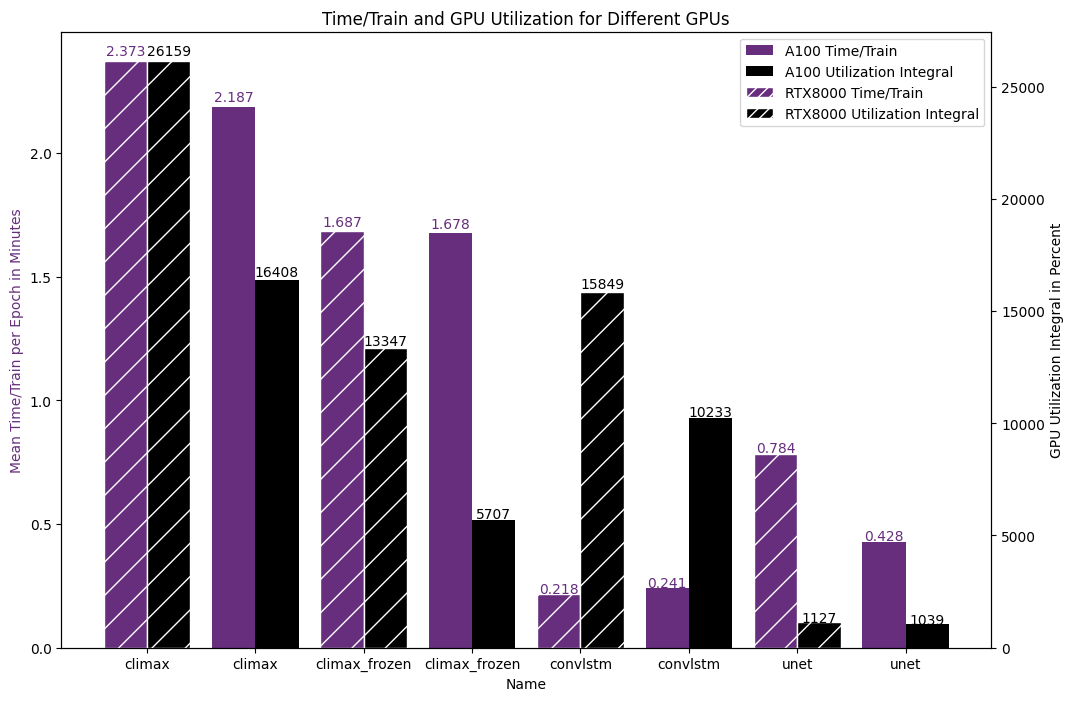

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your dataframe
df = merged_df_summary
print(df)
# Set up the plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the Time/Train Mean_Minutes with dashed bars for Treatment == 2
ax1.set_xlabel('Name')
ax1.set_ylabel('Mean Time/Train per Epoch in Minutes', color='#662E7D')
bars1 = ax1.bar(df.index - 0.2, df['Time/Train Mean_Minutes'], width=0.4, label='Mean Time/Train per Epoch in Minutes', color='#662E7D')
for i, bar in enumerate(bars1):
    if df['Treatment'][i] == "RTX8000":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Create a second y-axis for RMSE
ax2 = ax1.twinx()
ax2.set_ylabel('GPU Utilization Integral in Percent', color='black')
bars2 = ax2.bar(df.index + 0.2, df['GPU_Percent'], width=0.4, label='GPU Utilization Integral', color='black')
for i, bar in enumerate(bars2):
    if df['Treatment'][i] == "RTX8000":
        bar.set_hatch('/')
        bar.set_edgecolor("white")

# Adding names as x-axis labels
ax1.set_xticks(df.index)
ax1.set_xticklabels(df['Name'])

# Annotate the bars with Treatment values
for i in range(len(df)):
    ax1.text(df.index[i] - 0.2, df['Time/Train Mean_Minutes'][i]*1.01, str(df['Time/Train Mean_Minutes'][i]), ha='center', color='#662E7D')
    ax2.text(df.index[i] + 0.2, df['GPU_Percent'][i] *1.01, str(df['GPU_Percent'][i]), ha='center', color='black')

# Add legend with grouped labels
purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D", hatch="")
black_patch = plt.Rectangle((0, 0), 1, 1, fc="black", hatch="")
dashed_purple_patch = plt.Rectangle((0, 0), 1, 1, fc="#662E7D",edgecolor="white", hatch="///")
dashed_black_patch = plt.Rectangle((0, 0), 1, 1, fc="black",edgecolor="white", hatch="///")

# dashed_purple_patch = plt.Line2D([], [], color="purple", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline Time')
# dashed_black_patch = plt.Line2D([], [], color="black", marker='', linestyle='None', markersize=10, markerfacecolor='white', label='Baseline RMSE')
plt.legend(handles=[purple_patch, black_patch, dashed_purple_patch, dashed_black_patch],
           labels=['A100 Time/Train', 'A100 Utilization Integral', 'RTX8000 Time/Train', 'RTX8000 Utilization Integral'], loc='upper right')
plt.title('Time/Train and GPU Utilization for Different GPUs')

# Save the figure
fig.savefig("figures/RQ_2.2_combined_bar/RQ_2.2_combined_bar.png")

# Show plot
plt.show()


In [18]:
newdfforthis = pd.DataFrame(arr_of_integrals)

# Split column names and extract the first part as the treatment
names = list(set(newdfforthis.columns.str.split('-').str[0]))
newdfforthis['names'] = names

# Reorder the columns with 'treatment' as the first column
cols = ['names'] + [col for col in newdfforthis.columns if col != 'names']
data = newdfforthis[cols]

df = pd.DataFrame(data)

# Extract Baseline and A100 columns for each treatment
baseline_cols = [col for col in df.columns if 'Baseline' in col]
A100_cols = [col for col in df.columns if 'A100' in col]

# Create new columns for Baseline and A100
df['RTX8000'] = df[baseline_cols].sum(axis=1)
df['A100'] = df[A100_cols].sum(axis=1)

# Drop the old treatment-specific columns
df.drop(columns=baseline_cols + A100_cols, inplace=True)
print(df,"\n")
# Add a new column "Treatment"
df['Treatment'] = df.apply(lambda row: 'RTX8000' if 'RTX8000' in row['names'] else 'A100', axis=1)

# Melt the DataFrame to combine the "RTX8000_GPU" and "A100_GPU" columns into one column called "GPU"
df = pd.melt(df, id_vars=['names', 'Treatment'], var_name='GPU', value_name='value')
df.drop(columns=['Treatment'], inplace=True)

# Rename the columns
df.rename(columns={'GPU': 'Treatment', 'value': 'GPU_Percent'}, inplace=True)


# Remove the "Treatment" column

print(df)

           names     RTX8000        A100
0  climax_frozen  13346.5550   5706.5350
1           unet   1127.4650   1038.7150
2       convlstm  15849.0075  10232.8325
3         climax  26159.4875  16407.5325 

           names Treatment  GPU_Percent
0  climax_frozen   RTX8000   13346.5550
1           unet   RTX8000    1127.4650
2       convlstm   RTX8000   15849.0075
3         climax   RTX8000   26159.4875
4  climax_frozen      A100    5706.5350
5           unet      A100    1038.7150
6       convlstm      A100   10232.8325
7         climax      A100   16407.5325
